# <span style="color:orange">Quality Data Analysis - Project Work </span>
## Team 13

### Course Details:
- Academic Year: 2022-2023

### Project Details:
- Title: Quality Data Analysis: In-line fan cover detection

### Team Members:
- [Iacopo Rossi ]
- [Matteo Zanovello]
- [Samuele Zenoni]
- [Michela Zilioli 10938853]

### Instructor:
- [Panagiotis Tsiamyrtzis]
- [Grasso Marco]

# Instructions
- This is a template notebook for the project work.
- Please fill in the details above (team members, instructor, etc.)
## Report structure
Please use the following sections for your project report:
- **Introduction** [max 3500 characters including spaces]
    - Recap the project work framework and objective
    - Briefly summarize the overall methodology you used to achieve your final proposed solution
    - Briefly summarize the state-of-the-art you analysed to support your study (if any).
- **Assumptions** [max 3500 characters including spaces]
    - Clearly state and motivate all the assumptions your proposed methodology relies on. 
- **Proposed Methodology** [max 10000 characters including spaces]
    - Synthetically describe, motivate and critically discuss your proposed methodology, your trade-off analysis and your final solution. 
- **Results** [max 10000 characters including spaces]
    - Briefly present your results. Support your discussion with all the necessary quantitative computations and graphical representations.

You can add code cells to any of the above sections to show some code or display images. Each block of code should be accompanied by a brief description of what it does.

## Submission
- Name your notebook as `teamXX.ipynb` where `XX` is your team number.
- Submit your notebook on Webeep by the deadline. 

# Introduction

The project's aim is to develop an automated defect detection system for a polymer 3D printed fan cover using inline vision-based quality analysis. 
The fan cover samples can be classified into five distinct categories: defect-free, missing material along the border, missing material in the corner, broken struts, and severe lack of struts. 

The proposed solution enables the detection of all categories of fan covers, by dividing into three main groups: in-control fan covers, border-defective fan covers, and internally defective fan covers. 

Initially, the images were processed by binarization, cropping, and rotation. Consequently, they were classified as in-control or out-of-control and stored in an array.

A data frame is created by stacking three arrays, each one related to one of the following parameters:
-	external perimeter of the fan cover
-	perimeter of the largest hole
-	number of holes

Principal Components Analysis is performed on these three variables; scores are assessed to reduce the dimensionality of data and to merge the most dominant features to simplify the model.

Two principal components were chosen such that cumulative explained variability is higher than 80% and data can be easily visualized in a 2D plot. 
It was decided, then, to fit individual control charts on the scores z1 and z2, finally PCA results were plotted in a scatter plot to verify the correct identification of in-control and out-of-control images.

To apply the SPC on the scores, assumptions of normality and independence were evaluated.  
Subsequently passing to phase 2, the remaining images are projected onto the selected principal components, scores were computed and plotted on the previously created control chart. 

Further analysis then performed on results coming from the PCA (in control founded images) so to check that everything is correctly detected.
Finally some other analyses were conducted to identify even the type of defect: an individual control chart is constructed for the external perimeter of the fan cover to evaluate border defects, while the remaining out-of-control result belongs to second type of error (Internal defects).
Average run length on null hypothesis (ARL_0) is finally assessed using the Bonferroni inequality as the 2 control charts on the scores has to be applied concurrently.



# Assumptions

Image collection took place at the MADE Competence Centre. The dataset acquisition strategy was chosen in collaboration with student representatives from other groups. It was decided to place the fan covers on the automatic line tray in groups of varying numbers (4/5/6 fan cover per tray). The acquisition carried out in this way has both positive and negative aspects: the model works even with more pieces at a time, but the different positions and so the illumination of the fan covers made images different from the point of view of light/shadow balance.

After an image processing correction (shown in the next section), 3 main characteristics were identified; all these parameters were evaluated by means of white pixels counting (region props analysis). 

All proposed analyses and methodologies were implemented using Python; the following libraries were used:
-	numpy as np
-	matplotlib.pyplot as plt
-	cv2
-	skimage
-	from PIL import Image
-	scipy import ndimage
-	os
-	glob
-	pandas as pd
-	from sklearn.preprocessing import StandardScaler
-	from sklearn.decomposition import PCA

All the other assumptions related to the presented methodology are described when needed before its application. 


# Proposed Methodology

### Image correction

The image processing is a preliminary stage considered fundamental for the implementation of subsequent analyses. 
Starting from raw images each single fan cover was identified, processed and saved as a new single image. 

First, the paths for the input images folder (qda_data_start) and the destination folder (qda_data_bin) were defined. Then a loop cycle was implemented to make sure that all the actions, defined later, were applied to each input image:
-	Reading and converting each image to grayscale using cv2_imread function and applying binary thresholding setting the thresh value at 45;
-	Reducing noise using median filtering and filling gaps in figures through morphological closing.
-	Finding contours of the figures in the processed image.
-	Extracting individual figures and performing edge detection and line detection using the Hough transform.
-	Rotating the figures based on the detected lines, 
-	Resizing to have a standard dimension of 300x300 pixels.
-	Creating new images and saving them in the destination folder



In [6]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from PIL import Image
from scipy import ndimage
import os
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [7]:
# Image correction
# path to the images folder
img_path = "./qda_data_start/"
save_path = "./qda_data_bin/"

# loop through all image files in the folder
i=0
for file_path in glob.glob(os.path.join(img_path, "*.png")):
       
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # Set the threshold value
    thresh_value = 45
    # Apply binary thresholding
    ret, img = cv2.threshold(img, thresh_value, 255, cv2.THRESH_BINARY)
    #filter
    img= cv2.medianBlur(img, 5)
    # Apply morphological closing to fill in any gaps in the figures
    kernel = np.ones((3,3),np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    # Find the contours of the figures
    contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create a list to store the individual figure images
    figures = []
    # Loop over the contours
    for contour in contours:
        # Get the bounding box of the contour
        x,y,w,h = cv2.boundingRect(contour)

        # Extract the figure from the image and add it to the list
        figure = img[y:y+h, x:x+w]
        figures.append(figure)   
        
    for figure in figures:
        if (figure.shape[0]<100 and figure.shape[1]<100):
            continue
        i += 1
        edges = cv2.Canny(figure, 100, 200, L2gradient=True)
        # Apply Hough transform to find lines
        lines = cv2.HoughLines(edges, 1, np.pi/180, 100)
        
        angle = None
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))

            y1 = -y1 # For the change of origin
            y2 = -y2 # For the change of origin

            if x1 == x2: # In case of same x
                x2 += 0.01
            if y1 == y2: # In case of same y
                y2 += 0.01

            # Find theta from the slope
            angle = np.arctan((y2-y1)/(x2-x1))*57.296

            if -90 < angle < -30 :
                angle += 180
            if -30 < angle < 0 :
                angle += 360
            break
        if 360 > angle >= 270:
            figure = ndimage.rotate(figure, angle=360-angle, reshape=False)
        elif 270 > angle >= 30:
            figure = ndimage.rotate(figure, angle=90-angle, reshape=False)
        elif 30 > angle >= 0:
            figure = ndimage.rotate(figure, angle=-angle, reshape=False)
        
        
        # Get the dimensions of the original image
        h, w = figure.shape[:2]

        # Create a new blank image with the desired size
        new_figure = np.zeros((300, 300), np.uint8)
        # Calculate the x and y coordinates to place the original image in the center of the new image
        x = (300 - w) // 2
        y = (300 - h) // 2

        # Paste the original image onto the new image
        new_figure[y:y+h, x:x+w] = figure
        
        figure_path = os.path.join(save_path, f"figure_{i}.png")
        #cv2.imwrite(figure_path, new_figure)

# Proposed Methodology

### Principal components analysis

Principal component analysis (PCA) is a dimensionality reduction technique used to transform large datasets into smaller ones while retaining a significant portion of the original information.

By reducing the number of variables in a dataset, PCA trades a small loss of accuracy for the benefit of simplicity. This simplification allows for easier data exploration, visualization and analysis.
In order to understand whether an image was faulty or not, three variables were defined to capture information about the state of the images. By mean of region props function, all the variables were assessed and store in an array. The external perimeter of the fan cover, the perimeter of the largest internal hole and the number of holes. These variables were then used to create a data frame. 
After constructing the data frame, PCA was performed on the variables of a subset of the pieces in control, 2PCs were chosen, explaining 80.12% of the variability and the scores obtained were then plotted on a 2D plot. 

A scatter plot was performed on Z1 and Z2 scores and a circle with 95 percentile radius calculated on the distances between the mean (x_mean = mean(Z1); Y_mean = mean(Z2)) and the scatter points of each in-control product was then inserted to better visualize the distribution of the data. In-control fan covers were plotted in blue while out-of-control ones were plotted in green, while in yellow(not detected out of control)  and red(not detected in control) are depicted respectively the errors of the PCA visual test. 


In [8]:
img_array = []

x1 = [] # external perimeter
x2 = [] # biggest perimeter of internal holes
x3 = [] # number of holes (that has area bigger than 25 pixels)


# loop through all image files in the folder
for file_path in glob.glob(os.path.join(save_path, "*.png")):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img_array.append(img)

    edges = cv2.Canny(img, 100, 100)
    labels = skimage.measure.label(edges)
    props = skimage.measure.regionprops(labels)
    p = [prop.perimeter for prop in props]
    p = sorted(p, reverse=True)
    x1.append(p[0])
    x2.append(p[1])

    img = cv2.bitwise_not(img)
    edges = cv2.Canny(img, 100, 100)
    labels = skimage.measure.label(edges)
    props = skimage.measure.regionprops(labels)
    p = [prop.perimeter for prop in props]
    a = [prop.area for prop in props] 
    centroids = [prop.centroid for prop in props]
    p = sorted(p, reverse=True)
    cen_cont = [prop.centroid for prop in props]
    cen = []
    for i in range(1,len(p)): # skip the 1 data that is the center of the image
        if a[i] > 25:
            cen.append(centroids[i])
    x3.append(len(cen))
    
    
matrix = np.vstack((x1, x2, x3))
data = pd.DataFrame(matrix.T)

# Extract a subset of the data with only the first 24 rows
lim = int(0.8*30)
data_in = data.iloc[:lim, :] # 80% of in-control images (so first 24 images)

# Standardize the data by subtracting the mean and dividing by the standard deviation
data_in_std = (data_in - data_in.mean()) / data_in.std()
data.head()

,0,1,2


In [9]:
# PCA
# import the libraries for PCA
from sklearn.decomposition import PCA
# Create the PCA object
pca_std = PCA()
# Fit the PCA object to the data
pca_std.fit(data_in_std)

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(pca_std.explained_variance_, 'o-')
ax[0].grid()
ax[0].set_title('scree plot')
ax[0].set_ylabel('Eigenvalue')
ax[0].set_xlabel('Component number')

ax[1].plot(np.cumsum(pca_std.explained_variance_ratio_), 'o-')
ax[1].grid()
ax[1].set_title('Cumulative explained variance')
ax[1].set_ylabel('Cumulative explained variance')
ax[1].set_xlabel('Component number')



ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

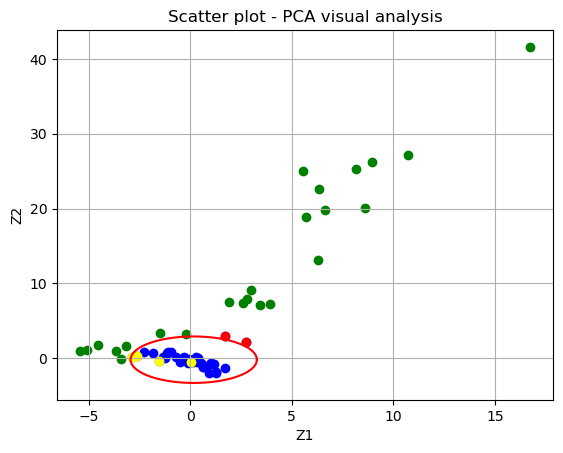

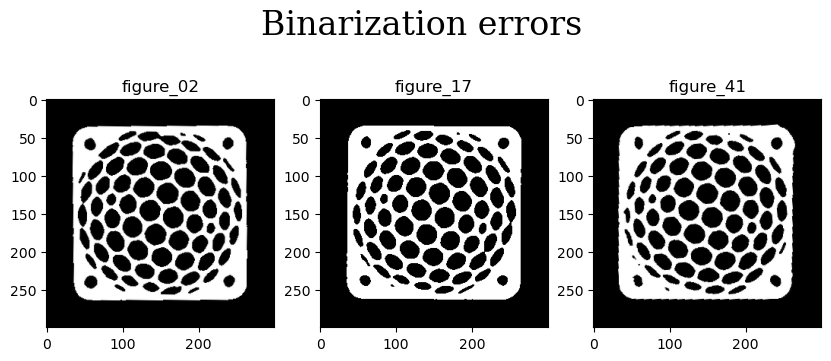

In [ ]:
# Standardize the data by subtracting the mean and dividing by the standard deviation
data_std = (data - data_in.mean()) / data_in.std()

# Compute the scores
scores = pca_std.transform(data_std)
# create a dataframe with the scores
scores_df = pd.DataFrame(scores, columns = ['z1', 'z2', 'Z3'])
# Print the first rows of the scores dataframe
scores_df.head()

# Create a scatterplot with the in-control values
x_in = scores_df['z1'][:30]
y_in = scores_df['z2'][:30]
x_out = scores_df['z1'][30:]
y_out = scores_df['z2'][30:]

plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('Scatter Plot')
plt.grid()


center = np.mean(x_in), np.mean(y_in)

dist = np.sqrt((x_in - center[0])**2 + (y_in - center[1])**2)

distances = np.sqrt((np.array(x_in) - center[0]) ** 2 + (np.array(y_in) - center[1]) ** 2)
distances1 = np.sqrt((np.array(x_out) - center[0]) ** 2 + (np.array(y_out) - center[1]) ** 2)

radius = np.percentile(dist, 95)
# Define angle range for plotting the circle
theta = np.linspace(0, 2*np.pi, 100)
# Generate points on the circle
circle_x = center[0] + radius * np.cos(theta)
circle_y = center[1] + radius * np.sin(theta)

# Create a Boolean array indicating points outside the circle
outside_circle = distances > radius
inside_circle1 = distances1 <= radius

# Plot scatter plot of the data points
plt.scatter(x_in, y_in, color = "blue")
plt.scatter(x_out,y_out, color = "green")
# Plot the points outside the circle in red
plt.scatter(np.array(x_in)[outside_circle], np.array(y_in)[outside_circle], color='red', label='Outside Circle')
plt.scatter(np.array(x_out)[inside_circle1], np.array(y_out)[inside_circle1], color='yellow', label='Inside Circle')


# Plot the circle
plt.plot(circle_x, circle_y, color='red', label='Circle')
plt.title('Scatter plot - PCA visual analysis')
plt.show()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (10,4))
ax[0].set_title('figure_02')
ax[1].set_title('figure_17')
ax[2].set_title('figure_41')
fig.suptitle("Binarization errors", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, [img_array[1], img_array[16], img_array[40]]):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')



The result of the scatter plot is biased by the effect of the binarization process (see assumption section); specifically, fig_02 and fig_17 are in-control images that are found out of control due to misleading lacks of structure. Viceversa, fig_41 is an out-of-control piece due to a corner defect that is not visible after the binarization.

# Proposed Methodology

### Control charts

To analyse and identify the observations in the "out-of-control" state, an I-Chart with gapping on the "scores" derived from PCA was adopted.
Since in the case under consideration the number of measurements for each fan cover is unitary, Individual control chart was considered.
The "scores" derived from PCA turn out to be autocorrelated with each other going against the assumptions necessary to apply the I Chart, consequently a gapping of size 2 was performed. 

"Gapping" is a technique used in statistics to handle autocorrelated or correlated data. In general, gapping involves removing or skipping some observations within a data set, creating an interval between selected observations.

The application of gapping also has some disadvantages:
-	Loss of information — By removing or skipping some observations, some of the original data is lost.
This could result in loss of valuable information and reduce the accuracy of estimates or statistical analysis.
-	Introduction of bias — Gapping could introduce bias into the data, especially if the selection of observations to be skipped is not done randomly.

The consideration of batching was also taken into account to reduce autocorrelation between the data. However, it was ultimately discarded because it compressed the new batched data towards the mean value (hagging effect). 
Then Normality test was performed using the Shapiro-Wilk test on gapped data.

After gapping is applied, the data are found to belong to: $X \sim N(\mu, \sigma) iid$.
The process parameters (mean $\mu$ and variance $\sigma$) are unknown a priori, consequently corresponding estimators were introduced:
$$ \mu = \bar{X} = \frac{1}{n} *\sum X_j$$
$$ \sigma = \bar{MR}/d2(2)$$
Where:
- $\bar{MR}$ is defined as the average value of the difference between each value and its successive.
- d2(2) is the number of factors for the center, in the case considered d2(2) = 1.128

Once these parameters were defined, the I-control chart and its limits can be identified as:
$$ UCL = \bar{X} + K*(\bar{MR}/d2(2) ) $$
$$ CL = \bar{X} $$
$$ LCL = \bar{X} - K*(\bar{MR}/d2(2) ) $$
Where $K = 3$ to obtain a 99.7% confidence level.

Usually in addition to the I-Chart, the MR-Control Chart is also defined, to obtain an I-MR Chart.
The analysis of the data on the I-MR Chart is used to identify observations that are out of control and thus give an alarm signal.
In the case under consideration, however, the check on the MR Control Chart was not done because this would have led to a high number of false positives since data were time independent and so they did not follow a meandering pattern. This leads to a low robustness analysis.
Due to binarization error, two of the in-control images were pointed out as out of control and so not considered in the dataset, as result from scatterplot of scores.

80% of in-control data (22 of 28) were used to build the control charts (design phase) but given the presence of autocorrelation, gapping methodology was adopted and a new data set of 11 fan covers was created.

In conclusion, for the reasons listed above, it was decided to conduct an analysis considering only the I-Chart to identify observations "out-of-control" state. 


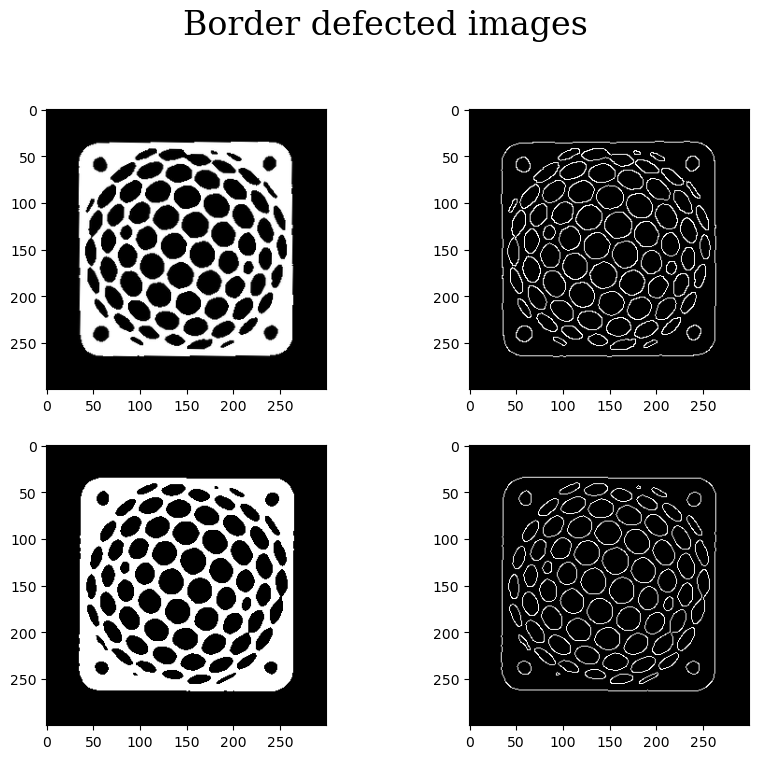

In [ ]:
# Binarization errors
img_out = []

img_1 = cv2.imread("qda_data_bin/figure_02.png",cv2.IMREAD_GRAYSCALE)
img_out.append(img_1)
# Perform Canny edge detection
edges_1 = cv2.Canny(img_1, 100, 100)
img_out.append(edges_1)
img_2 = cv2.imread("qda_data_bin/figure_17.png",cv2.IMREAD_GRAYSCALE)
img_out.append(img_2)
# Perform Canny edge detection
edges_2 = cv2.Canny(img_2, 100, 100)
img_out.append(edges_2)


fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))
fig.suptitle("Border defected images", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, img_out):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')

Runs test p-value = 0.869
The null hypothesis is accepted


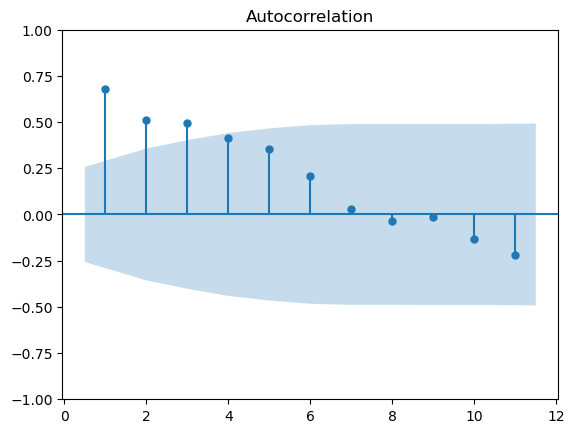

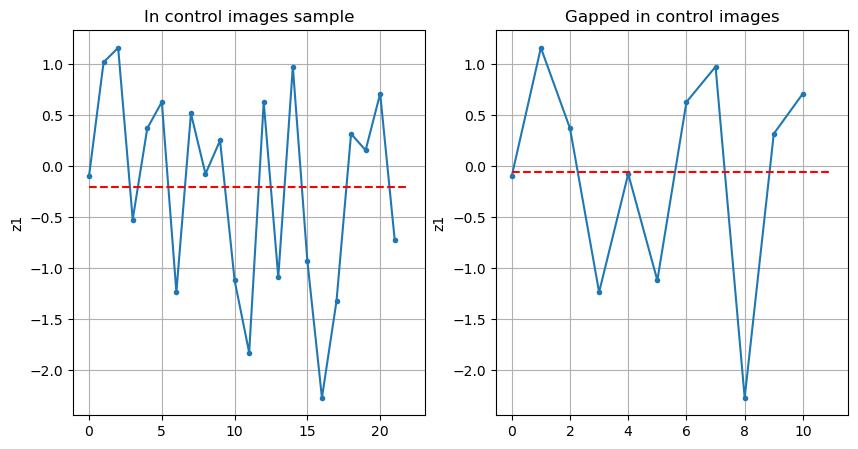

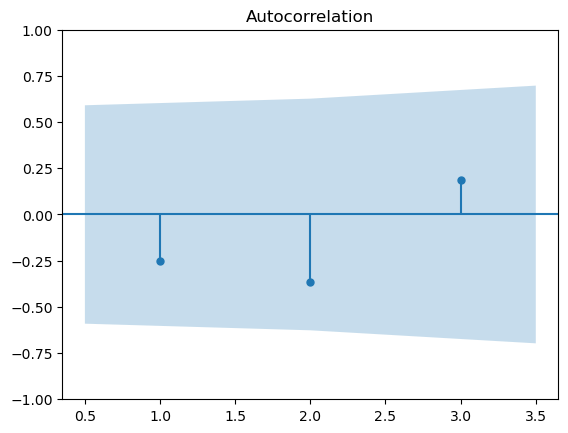

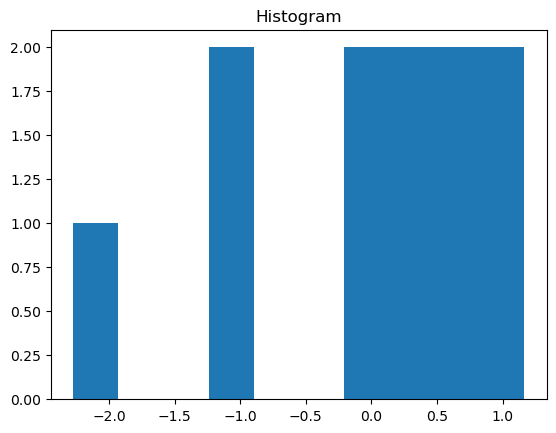

Statistic = 0.904, p-val = 0.206
Fail to reject H0


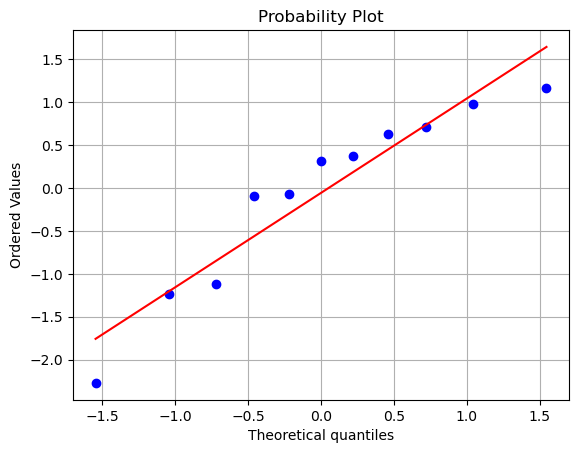

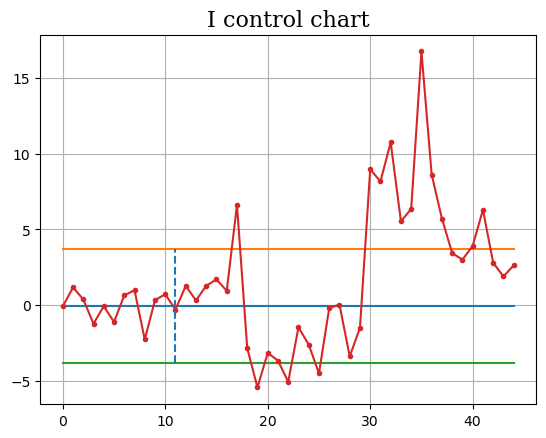

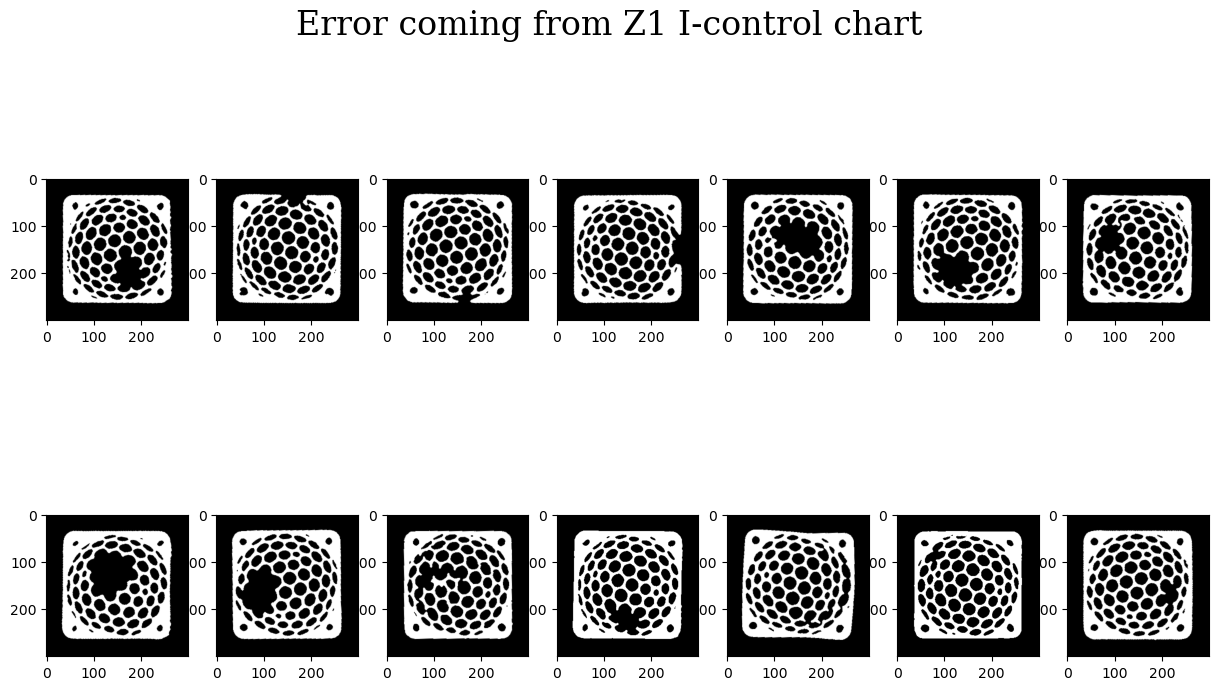

In [ ]:
# array of in control images (sample of 80% of the total in control images)
# 2 images are eliminated because of binarization problems
z1_good = ([scores_df['z1'][0]] + list(scores_df['z1'][2:16]) + list(scores_df['z1'][17:lim]))
z1_mean = np.mean(z1_good)

z1 = scores_df['z1']

# checking the assumptions
# runs test
from statsmodels.sandbox.stats.runs import runstest_1samp
stat_runs, pval_runs = runstest_1samp(z1_good, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))
if pval_runs < 0.05:
    print('The null hypothesis is rejected')
else: print('The null hypothesis is accepted')

import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(z1, lags = int(len(z1_good)/2), zero=False)
plt.show()

# Apply gapping operation to remove independence
z1_good_ind = []

for i in range(int(len(z1_good)/2)):
    z1_good_ind.append(z1_good[i*2])

fig, ax = plt.subplots(1, 2, figsize= (10, 5))
ax[0].plot(z1_good,'.-')
ax[0].grid()
ax[0].hlines(z1_mean, 0, len(z1_good), colors='red', linestyles='dashed')
ax[0].set_title('In control images sample')
ax[0].set_ylabel('z1')

ax[1].plot(z1_good_ind,'.-')
ax[1].grid()
ax[1].hlines(np.mean(z1_good_ind), 0, len(z1_good_ind), colors='red', linestyles='dashed')
ax[1].set_title('Gapped in control images')
ax[1].set_ylabel('z1')


import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(z1_good_ind, lags = int(len(z1_good_ind)/3), zero=False)
plt.show()

z1_good_ind_mean = np.mean(z1_good_ind)

#Shapiro-Wilk test
from scipy.stats import shapiro
from scipy import stats

plt.hist(z1_good_ind)
plt.title('Histogram')
plt.show()

stat_shapiro_out, p_shapiro_out = shapiro(z1_good_ind)
print('Statistic = %.3f, p-val = %.3f' % (stat_shapiro_out, p_shapiro_out))
# interpret
alpha = 0.05
if p_shapiro_out > alpha:
    print('Fail to reject H0')
else:    
    print('Reject H0')

# Plot the qqplot
stats.probplot(z1_good_ind, dist="norm", plot=plt)
plt.grid()
plt.show()

# Calculate the moving range
mr = np.zeros(len(z1_good_ind)-1)

for i in range(len(mr)):
    mr[i] =np.abs(z1_good_ind[i+1] - z1_good_ind[i]) 

avg_mr_z1 = np.mean(mr)

K_1 = 3
cl_I_z1 = (z1_good_ind_mean)
ucl_I_z1 = (z1_good_ind_mean + K_1* avg_mr_z1/1.128)
lcl_I_z1 = (z1_good_ind_mean - K_1* avg_mr_z1/1.128)

z1 = z1.tolist()
z1_new_sample = z1_good_ind + z1[lim:] # new sample, gapped data (phase 1) + the test data in z1 sample

plt.plot(cl_I_z1* np.ones(len(z1_new_sample)))
plt.plot(ucl_I_z1 * np.ones(len(z1_new_sample)))
plt.plot(lcl_I_z1 * np.ones(len(z1_new_sample)))
plt.plot(z1_new_sample,'.-')
plt.vlines((lim-2)/2, lcl_I_z1, ucl_I_z1, linestyles='dashed')
plt.title("I control chart", fontdict={'size':16, 'family':'serif'})
plt.grid()
plt.show()

# vector of the border defected images
def_z1 = []

for i in range(int(lim),len(z1)):
    if (z1[i] > ucl_I_z1 or z1[i] < lcl_I_z1):
        def_z1.append(i)


b_def = []
k = 0
for file_path in glob.glob(os.path.join(save_path, "*.png")):   
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if k in def_z1:
        b_def.append(img)
    k += 1

fig, ax = plt.subplots(nrows = 2, ncols = 7, figsize = (15,8))
fig.suptitle("Error coming from Z1 I-control chart", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, b_def):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')



In [ ]:
z2_good = ([scores_df['z2'][0]] + list(scores_df['z2'][2:16]) + list(scores_df['z2'][17:lim]))
z2_mean = np.mean(z2_good)

z2 = scores_df['z2']

# checking the assumptions
# runs test
from statsmodels.sandbox.stats.runs import runstest_1samp
stat_runs, pval_runs = runstest_1samp(z2_good, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))
if pval_runs < 0.05:
    print('The null hypothesis is rejected')
else: print('The null hypothesis is accepted')

import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(z2, lags = int(len(z2_good)/2), zero=False)
plt.show()

# Apply gapping operation to remove independence
z2_good_ind = []

for i in range(int(len(z2_good)/2)):
    z2_good_ind.append(z2_good[i*2])

fig, ax = plt.subplots(1,2, figsize = (12, 5))
ax[0].plot(z2_good,'.-')
ax[0].grid()
ax[0].hlines(z2_mean, 0, len(z2_good), colors='red', linestyles='dashed')
ax[0].set_title('In control images sample')
ax[0].set_ylabel('z2')

ax[1].plot(z2_good_ind,'.-')
ax[1].grid()
ax[1].hlines(np.mean(z2_good_ind), 0, len(z2_good_ind), colors='red', linestyles='dashed')
ax[1].set_title('Gapped in control images')
ax[1].set_ylabel('z2')

import statsmodels.graphics.tsaplots as sgt
sgt.plot_acf(z2_good_ind, lags = int(len(z2_good_ind)/3), zero=False)
plt.show()

z2_good_ind_mean = np.mean(z2_good_ind)

#Shapiro-Wilk test
from scipy.stats import shapiro
from scipy import stats

plt.hist(z2_good_ind)
plt.title('Histogram')
plt.show()

stat_shapiro_out, p_shapiro_out = shapiro(z2_good_ind)
print('Statistic = %.3f, p-val = %.3f' % (stat_shapiro_out, p_shapiro_out))
# interpret
alpha = 0.05
if p_shapiro_out > alpha:
    print('Fail to reject H0')
else:    
    print('Reject H0')

# Plot the qqplot
stats.probplot(z2_good_ind, dist="norm", plot=plt)
plt.grid()
plt.show()

# Calculate the moving range
mr = np.zeros(len(z2_good_ind)-1)

for i in range(len(mr)):
    mr[i] =np.abs(z2_good_ind[i+1] - z2_good_ind[i]) 

avg_mr_z2 = np.mean(mr)

z2 = z2.tolist()
z2_new_sample = z2_good_ind + z2[lim:] # new sample, gapped data (phase 1) + the test data in z1 sample

K_2 = 3
cl_I_z2 = (z2_good_ind_mean)
ucl_I_z2 = (z2_good_ind_mean + K_2* avg_mr_z2/1.128)
lcl_I_z2 = (z2_good_ind_mean - K_2* avg_mr_z2/1.128)

plt.plot(cl_I_z2* np.ones(len(z2_new_sample)))
plt.plot(ucl_I_z2 * np.ones(len(z2_new_sample)))
plt.plot(lcl_I_z2 * np.ones(len(z2_new_sample)))
plt.plot(z2_new_sample,'.-')
plt.vlines((lim-2)/2, lcl_I_z2, ucl_I_z2, linestyles='dashed')
plt.title("I control chart", fontdict={'size':16, 'family':'serif'})
plt.grid()
plt.show()

# vector of the border defected images
def_z2 = []
for i in range(int(lim),len(z2)):
    if (z2[i] > ucl_I_z2 or z2[i] < lcl_I_z2):
        def_z2.append(i)

b_def = []
k = 0
for file_path in glob.glob(os.path.join(save_path, "*.png")):   
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if k in def_z2:
        b_def.append(img)
    k += 1

fig, ax = plt.subplots(nrows = 3, ncols = 6, figsize = (15,5))
fig.suptitle("Error coming from Z2 I-control chart", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, b_def):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')

NameError: name 'scores_df' is not defined

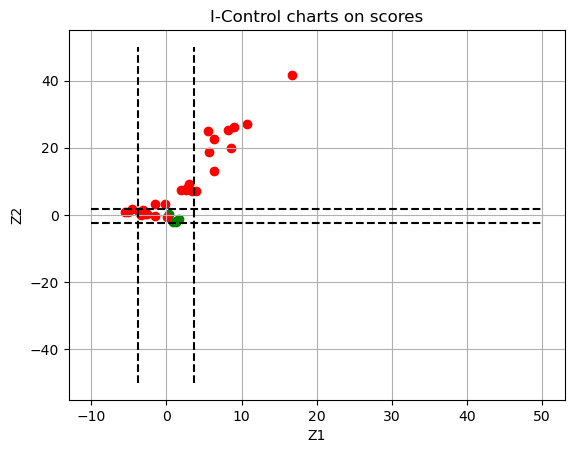

In [ ]:
plt.scatter(z1[25:30],z2[25:30], c='green') # In control
plt.scatter(z1[31:],z2[31:], c='red') # out of control
plt.grid()
plt.vlines(ucl_I_z1, -50, 50, linestyles='dashed', colors='black')
plt.vlines(lcl_I_z1, -50, 50, linestyles='dashed', colors='black')
plt.hlines(ucl_I_z2, -10, 50, linestyles='dashed', colors='black')
plt.hlines(lcl_I_z2, -10, 50, linestyles='dashed', colors='black')
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('I-Control charts on scores')
plt.show()


21


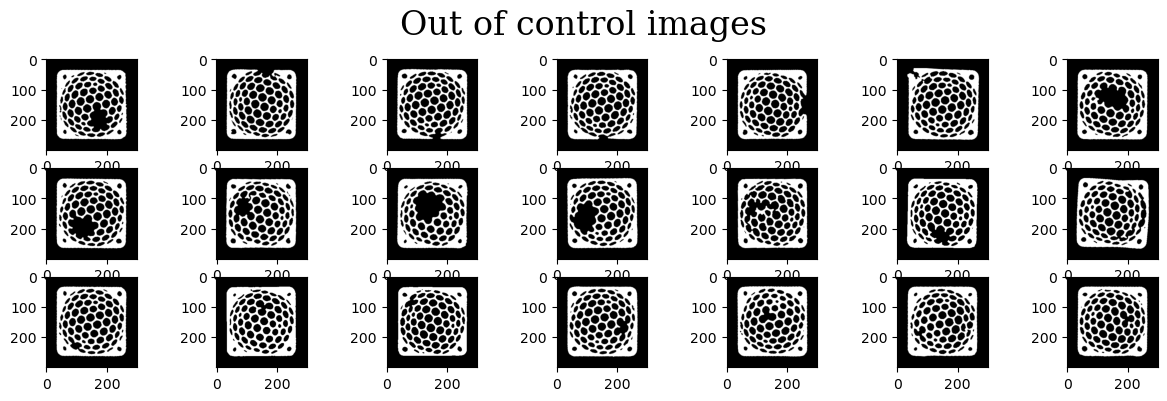

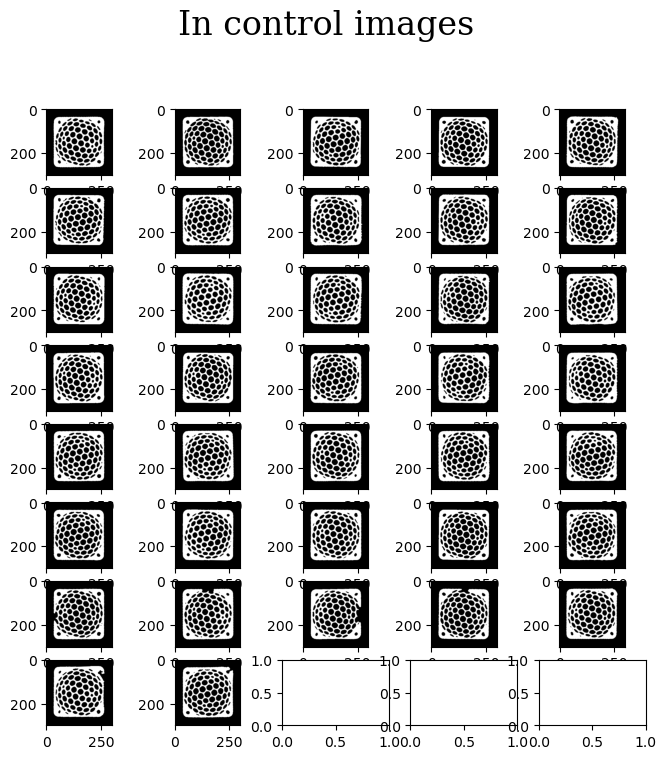

In [ ]:
defects_z = def_z1 + def_z2
defects_z = list(set(defects_z))
defects_z = sorted(defects_z)
print(len(defects_z))
b_def = []
b_nodef = []
k = 0
for file_path in glob.glob(os.path.join(save_path, "*.png")):   
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if k in defects_z:
        b_def.append(img)
    else: 
        b_nodef.append(img)
    k += 1

fig, ax = plt.subplots(nrows = 3, ncols = 7, figsize = (15,4))
fig.suptitle("Out of control images", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, b_def):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')

fig, ax = plt.subplots(nrows = 8, ncols = 5, figsize = (8,8))
fig.suptitle("In control images", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, b_nodef):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')

# Proposed Methodology

### Further analysis after PCA

After the performing of the PCA, 37 images were taken as in control (7 of 37 were out of control images), so further analyses can be made on the given in-control images, resulting from previous methodology, to detect the correctness of the sample.

The methodology presented thereby focuses specifically on border defects, which were in some cases difficult to identify by PCA alone. 
Since all the wrong detections were related to border defects a I control chart was built on the external perimeter, the variable that better explain the border variability. 

It was chosen to perform further analyses only on this variable, but in order to have a more complete and robust result another I-control chart can be performed on the perimeter of the largest internal hole so to detect if in the given in-control sample structural defects were present.


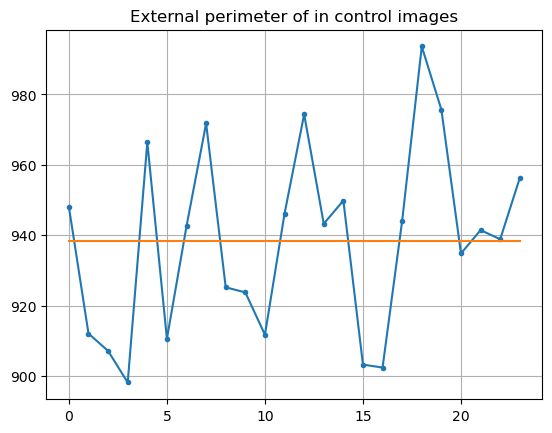

In [ ]:
ext_per = x1[:lim]
    
ext_per_mean = np.mean(ext_per)
plt.plot(ext_per,'.-')
plt.plot(ext_per_mean*np.ones(len(ext_per)))
plt.title('External perimeter of in control images')
plt.grid()
plt.show()

In [ ]:
# runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

stat_runs, pval_runs = runstest_1samp(ext_per, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))
if pval_runs < 0.05:
    print('The null hypothesis is rejected')
else: print('The null hypothesis is accepted')

Runs test p-value = 0.474
The null hypothesis is accepted


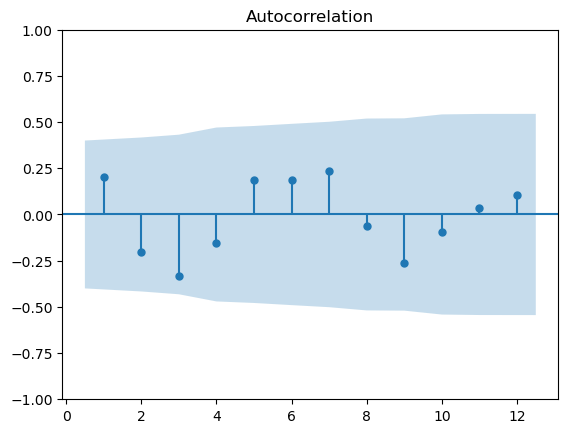

In [ ]:
# Check for autocorrelation
from statsmodels.tsa.stattools import acf
import statsmodels.graphics.tsaplots as sgt
n = len(ext_per)
#autocorrelation function
[acf_values, lbq, _] = acf(ext_per, nlags = int(np.sqrt(n)), qstat=True, fft = False)

sgt.plot_acf(ext_per, lags = int(len(ext_per)/2), zero=False)
plt.show()

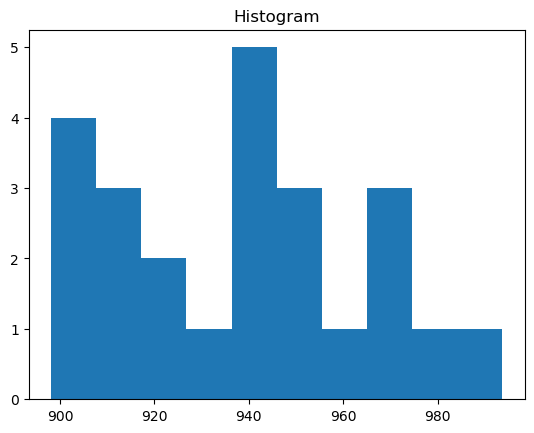

Statistic = 0.957, p-val = 0.380
Fail to reject H0


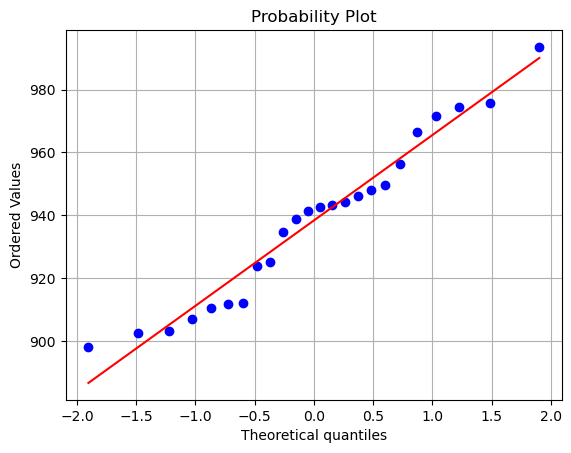

In [ ]:
#Shapiro-Wilk test
from scipy.stats import shapiro
from scipy import stats

plt.hist(ext_per)
plt.title('Histogram')
plt.show()

stat_shapiro_out, p_shapiro_out = shapiro(ext_per)
print('Statistic = %.3f, p-val = %.3f' % (stat_shapiro_out, p_shapiro_out))
# interpret
alpha = 0.05
if p_shapiro_out > alpha:
    print('Fail to reject H0')
else:    
    print('Reject H0')

# Plot the qqplot
stats.probplot(ext_per, dist="norm", plot=plt)
plt.grid()
plt.show()

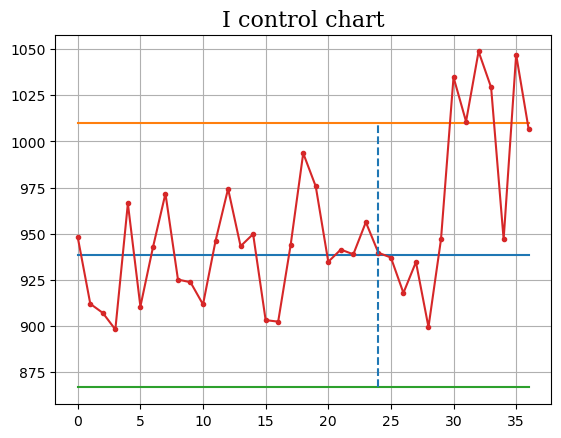

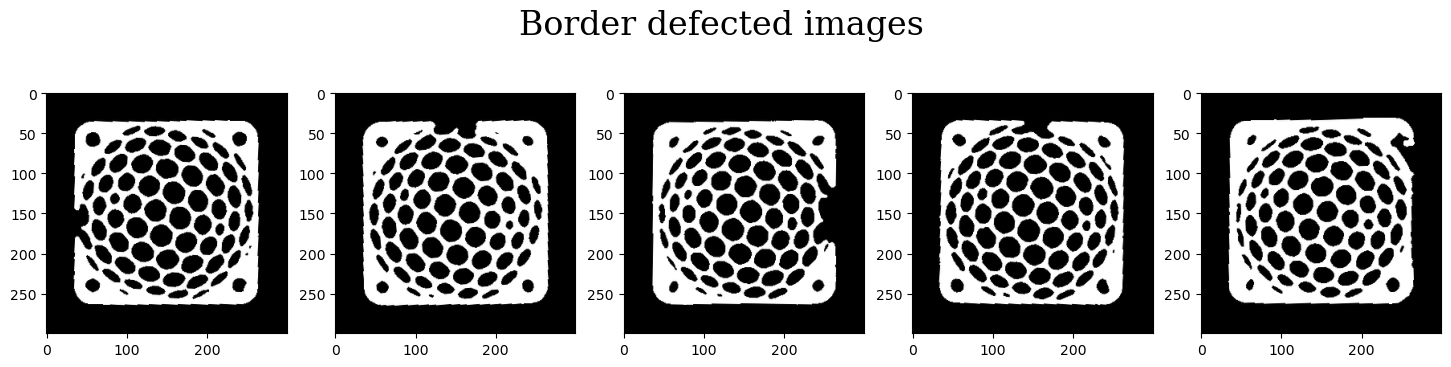

In [ ]:
# Calculate the moving range
mr = np.zeros(len(ext_per)-1)

for i in range(len(mr)):
    mr[i] =np.abs(ext_per[i+1] - ext_per[i]) 

avg_mr = np.mean(mr)

K = 3
cl_I_ext = (ext_per_mean)
ucl_I_ext = (ext_per_mean + K* avg_mr/1.128)
lcl_I_ext = (ext_per_mean - K* avg_mr/1.128)

x1_nodef = []
for img in b_nodef:
    edges = cv2.Canny(img, 100, 100)
    labels = skimage.measure.label(edges)
    props = skimage.measure.regionprops(labels)
    p = [prop.perimeter for prop in props]
    p = sorted(p, reverse=True)
    x1_nodef.append(p[0])

plt.plot(cl_I_ext* np.ones(len(x1_nodef)))
plt.plot(ucl_I_ext * np.ones(len(x1_nodef)))
plt.plot(lcl_I_ext * np.ones(len(x1_nodef)))
plt.plot(x1_nodef,'.-')
plt.vlines(24, lcl_I_ext, ucl_I_ext, linestyles='dashed')
plt.title("I control chart", fontdict={'size':16, 'family':'serif'})
plt.grid()
plt.show()

# vector of the border defected images
z = []

for i in range(len(x1_nodef)):
    if (x1_nodef[i] > ucl_I_ext or x1_nodef[i] < lcl_I_ext):
        z.append(i)

b_def_ext = []
k = 0
for img in b_nodef:   
    if k in z:
        b_def_ext.append(img)
    k += 1

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (18,4))
fig.suptitle("Border defected images", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, b_def_ext):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')

defects_z = [32,34,28,41,42] + defects_z
defects_z = sorted(defects_z)

5 out of 7 images from the PCA in control dataset were detected. One of the two missing images was actually a binarization error(Figure_41), while the other is simply not detected.

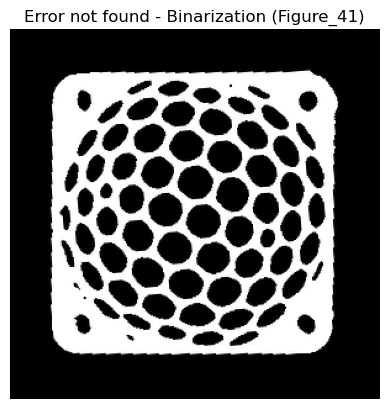

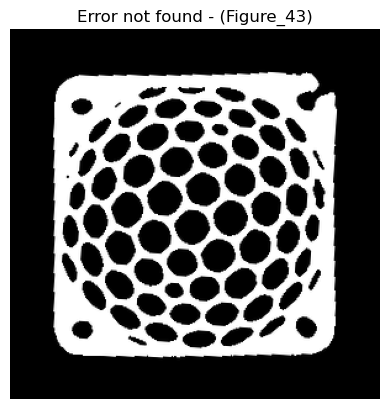

In [ ]:
# Plot of the error not found
img = cv2.imread("qda_data_bin/figure_41.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Error not found - Binarization (Figure_41)')
plt.show()

img = cv2.imread("qda_data_bin/figure_43.png",cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Error not found - (Figure_43)')
plt.show()

# Proposed Methodology

### Defect classification

The analyses conducted coming from the PCA and then from specific border detection identified if the sample was in control or out of control. In this section the typologies of the out-of-control image are detected.

Two different typologies of defects were analysed: firstly, the detection of the border and angular defects (border defected images), and the second one is the detection of structural defects and holes (internal defected images).

On the one hand the detection of border and angular defects was made by using Individual Control Charts, which were built on the first 80% of in-control image sample (24 images), and on the other hand internal defected images were found by difference as the remaining out-of-control images, assuming that if an image is border defected it can’t be internal defected.
Since the external perimeter of fan covers is the variable that better explains the variability between border defected images and in-control images, it was chosen as reference for building the control charts.

Hypothesis of Normality and Independence were checked on the sample of the external perimeters before constructing the Individual control Charts.
The control charts were constructed with a chosen value of K equal to 3. This selection results in an average run length (ARL_0) of 370 fan covers before detecting the first out-of-control piece.

All the calculations and the codes are reported in the following section and finally all the defected images are plotted. 


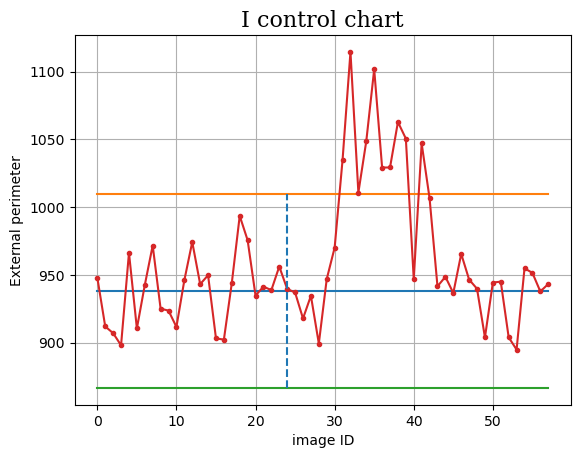

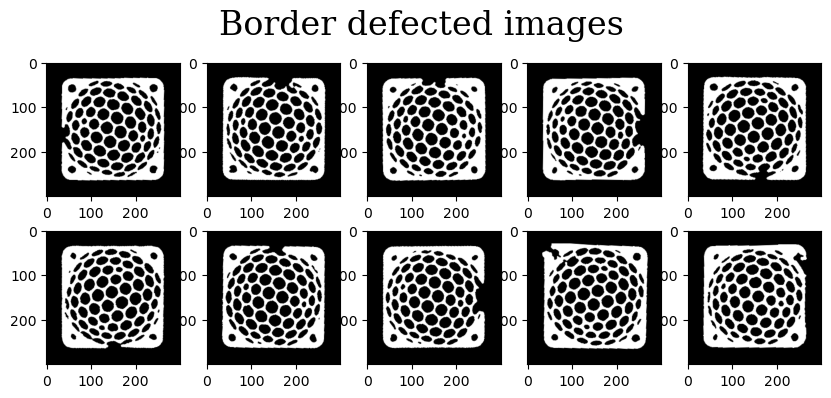

In [ ]:
# Defect classification
plt.plot(cl_I_ext* np.ones(len(x1)))
plt.plot(ucl_I_ext * np.ones(len(x1)))
plt.plot(lcl_I_ext * np.ones(len(x1)))
plt.plot(x1,'.-')
plt.vlines(24, lcl_I_ext, ucl_I_ext, linestyles='dashed')
plt.title("I control chart", fontdict={'size':16, 'family':'serif'})
plt.grid()
plt.ylabel('External perimeter')
plt.xlabel('image ID')
plt.show()

# vector of the border defected images

z = []
for i in range(len(x1)):
    if (x1[i] > ucl_I_ext or x1[i] < lcl_I_ext):
        z.append(i)

b_def = []
k = 0
for file_path in glob.glob(os.path.join(save_path, "*.png")):   
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if k in z:
        b_def.append(img)
    k += 1

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4))
fig.suptitle("Border defected images", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, b_def):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')

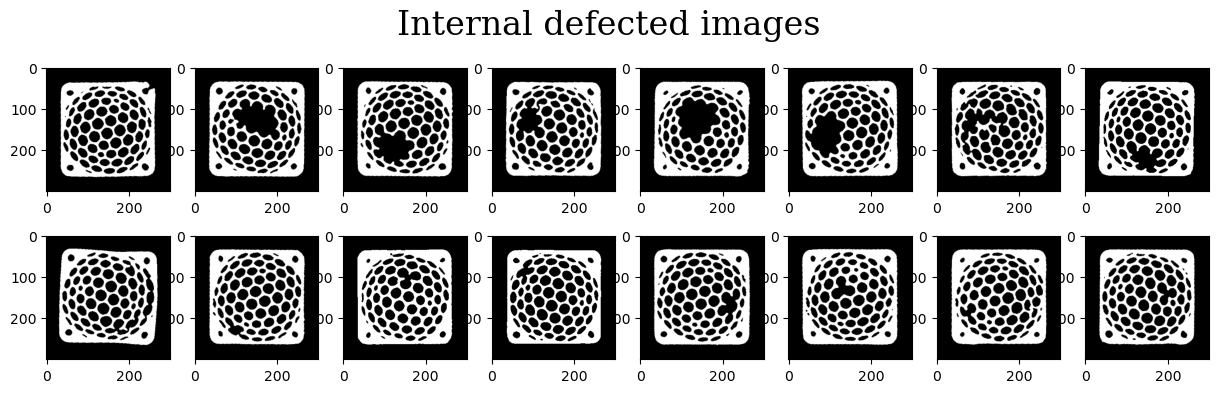

In [ ]:
# Internal defects are the one not highligthed by the I-chart on the external perimeter

defects = [x for x in defects_z if x not in z]
defects = list(set(defects))
defects = sorted(defects)
defects = defects[2:]

i_def = []
k = 0
for file_path in glob.glob(os.path.join(save_path, "*.png")):   
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if k in defects:
        i_def.append(img)
    k += 1


fig, ax = plt.subplots(nrows = 2, ncols = 8, figsize = (15,4))
fig.suptitle("Internal defected images", fontproperties = {'size':24, 'family':'serif'}, y=1.005);
for axs, i in zip (ax.flat, i_def):
    axs.set_xticks([])
    axs.set_yticks([])
    axs.imshow(i, cmap = 'gray')

# Results

Coming to conclusions we firstly ran the PCA section constructing the control charts with K=3 so to take confidence interval of data variations (99.7%) and it turned out that defected fan covers were correctly identified except for figure_41 and figure_43. In addition to this, two more figures were previously identified as binarized errors, namely figure_02 and figure_17. 
The results from the PCA analysis did not identify 7 images out of control, plotted above, out of a total of 28, thus corresponding to 25% of the observations. A more accurate error analysis showed that all of the false negative out-of-control images involved border defects, so it was decided to add an additional piece of code so as to minimize the possibility of error and identify as many out-of-control as possible. 
A perimeter-only analysis was performed on the results derived from PCA and concluded with an identification of 5 out of 7 out-of-control images (for a total of 26 out of 28).

The analysis derived from PCA, as set up in the methodology presented, correctly identified an error actually present in 79,5%; however, for the purpose of obtaining even a better identification result, it was necessary to add an additional control (94.12%). 
Further analysis of the data might be required, perhaps considering more variables in addition to those already considered (perimeter, number of internal holes and perimeter of the largest internal hole) and thus able to better explain the variability in the data, such as the area of the fan cover or the area of the largest internal hole. 

The ARL_0 was computed as the inverse of the probability of the first type error (alpha) and the results obtained were the same for both the control charts:

$$ARL_0 = 1/\alpha = 370$$ 
Being the two tests ran at the same time, Bonferroni inequality was applied to find the familywise alpha as the sum of the two-alpha used in the Control Charts, thus resulting:
$$\alpha = 0,0055$$

and consequently 
$$ARL_0 = 180$$

For each Control Chart a type 2-error analysis was performed by the construction of the relative Operative Characteristic Curve (OCC) by plotting the Type II error against Delta. The Type II error represents the probability of accepting the null hypothesis (H0) when the alternative hypothesis (H1) is actually true. 

To calculate beta, a hypothesis test on the equality of the means was conducted.
The hypotheses are as follows:
- H0: mu_new = CL 
- H1: mu_new != CL

where CL states for Central Line of the Control Chart.

mu_new is defined as mu + delta, where delta equals abs(mu_new – CL)/avg_mr. If H1 is true, the area under the normal distribution with a mean of CL and a standard deviation of avg_mr / sqrt(n) (where n = 11, namely the length of the gapped dataset) represents the probability of committing a Type II error.

Given that the two control charts were conducted simultaneously, to evaluate a Type II error, it is necessary for at least one out-of-control fan cover to be deemed in control. As the two control charts were independent, the family-wise Type II error was determined by multiplying the beta values of the two tests.
To evaluate ARL1 (Average Run Length under H1), the following formula was used: 
$$ARL1 = 1 / (1 – \beta)$$

As previously stated in the assumption section, a huge relevance is given to the binarization of the images. The conversion and the treatment of raw images directly influences the accuracy of the model as the variables themselves are assessed by means of the region props function on the processed images. Moreover, another influencing factor that is important to highlight is the simultaneous acquisition of pieces but from different perspectives on the same tray. This latter problem may be corrected by taking images only on one sample at a time with a reference system of acquisition (center and arrows). 



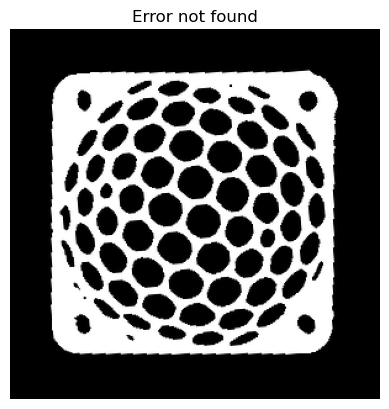

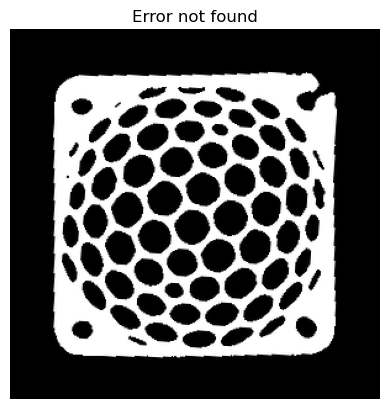

In [ ]:
# Plot of the error not found
img = cv2.imread("qda_data_bin/figure_41.png",cv2.IMREAD_GRAYSCALE)
img_out.append(img)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Error not found')
plt.show()

img = cv2.imread("qda_data_bin/figure_43.png",cv2.IMREAD_GRAYSCALE)
img_out.append(img)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Error not found')
plt.show()


In [ ]:
# Average run length
alpha_z1 = -(stats.norm.cdf(K_1)-1)*2
ARL0_z1 = 1 / alpha_z1
print ("Average run length for z1 is: %.3f" % ARL0_z1)

alpha_z2 = -(stats.norm.cdf(K_2)-1)*2
ARL0_z2 = 1 / alpha_z2
print ("Average run length for z2 is: %.3f" % ARL0_z2)

alpha = alpha_z1+alpha_z2 # Bonferroni inequality
ARL0 = 1 / alpha
print('ARL0: %.3f' % ARL0)

Average run length for z1 is: 370.398
Average run length for z2 is: 370.398
ARL0: 185.199


c:\Users\utente\anaconda3\envs\qda-project\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


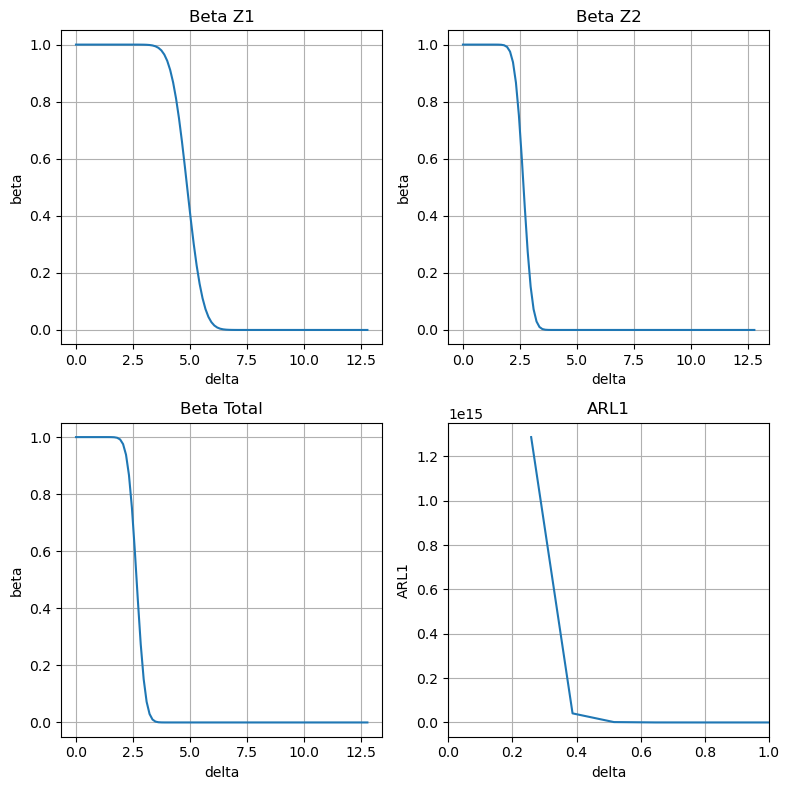

In [ ]:
# Beta calculation

# creation of a normal distribution having mu = CL_Z1 and sigma = avg_MR_z1
# Hypotesis test H0: mu_new = mu; H1 = mu_new != mu where mu_new = mu + delta

x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x, cl_I_z1, avg_mr_z1/np.sqrt((lim-2)/2))

# find the probability increasing delta to perform a type II error
d = np.arange(0, 10, 0.1)
delta = []
beta1 = []
for i in range (len(d)):
    mu_new = cl_I_z1+d[i]
    delta.append (((mu_new - cl_I_z1))/avg_mr_z1)
    beta1.append(stats.norm.cdf(ucl_I_z1, loc=mu_new, scale=avg_mr_z1/np.sqrt((lim-2)/2)) - stats.norm.cdf(lcl_I_z1, loc=mu_new, scale=avg_mr_z1/np.sqrt((lim-2)/2)))

x = np.linspace(-5, 5, 100)
y = stats.norm.pdf(x, cl_I_z2, avg_mr_z2/np.sqrt((lim-2)/2))

# find the probability increasing delta to perform a type II error
d = np.arange(0, 10, 0.1)
delta = []
beta2 = []
for i in range (len(d)):
    mu_new = cl_I_z2+d[i]
    delta.append (((mu_new - cl_I_z2))/avg_mr_z2)
    beta2.append(stats.norm.cdf(ucl_I_z2, loc=mu_new, scale=avg_mr_z2/np.sqrt((lim-2)/2)) - stats.norm.cdf(lcl_I_z2, loc=mu_new, scale=avg_mr_z2/np.sqrt((lim-2)/2)))

beta = np.array(beta1)*np.array(beta2)
ARL1 = 1 / (1 - np.array(beta))

fig, axs = plt.subplots(2, 2, figsize = (8,8))

axs[0, 0].plot(delta, beta1)
axs[0, 0].set_title('Beta Z1')
axs[0, 0].set_ylabel('beta')
axs[0, 0].set_xlabel('delta')
axs[0, 0].grid()

axs[0, 1].plot(delta, beta2)
axs[0, 1].set_title('Beta Z2')
axs[0, 1].set_ylabel('beta')
axs[0, 1].set_xlabel('delta')
axs[0, 1].grid()

axs[1, 0].plot(delta, beta)
axs[1, 0].set_title('Beta Total')
axs[1, 0].set_ylabel('beta')
axs[1, 0].set_xlabel('delta')
axs[1, 0].grid()

axs[1, 1].plot(delta, ARL1)
axs[1, 1].set_title('ARL1')
axs[1, 1].set_ylabel('ARL1')
axs[1, 1].set_xlabel('delta')
axs[1,1].set_xlim(0, 1)
axs[1, 1].grid()

fig.tight_layout()
plt.show()

# References (if any)